In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import keras

In [9]:
class_names = ['carpet', 'ceramic', 'glass', 'leather', 'metal', 'plastic', 'polishedstone', 'stone', 'wallpaper', 'wood']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)

In [10]:
def load_data(data_dir):
    images = []
    labels = []

    print(f"Loading data from {data_dir}...")

    # Iterate through each folder corresponding to a category
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        label = class_names_label.get(folder)
        if label is None:
            print(f"Skipping unknown folder: {folder}")
            continue

        # Initialize a counter for the number of images loaded for this class
        image_count = 0

        # Iterate through each image in the folder
        for file in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
            if image_count >= 1000:
                break  # Stop after loading 1000 images

            file_path = os.path.join(folder_path, file)
            try:
                # Read and preprocess the image
                image = cv2.imread(file_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append image and label to lists
                images.append(image)
                labels.append(label)

                # Increment the image counter
                image_count += 1
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")

    # Convert lists to numpy arrays
    images = np.array(images, dtype='float32') / 255.0  # Normalize pixel values
    labels = np.array(labels, dtype='int32')

    return images, labels

In [11]:
images, labels = load_data('D:/year 4 term 1/deep/New folder/minc-2500/images/aaa')

Loading data from D:/year 4 term 1/deep/New folder/minc-2500/images/aaa...


Processing wood:  40%|████      | 1000/2500 [00:44<01:06, 22.42it/s]


In [12]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.25, random_state=44, shuffle=True)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=44, shuffle=True)


# Print the shapes of the resulting datasets
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (6000, 150, 150, 3)
Test images shape: (2500, 150, 150, 3)
Train labels shape: (6000,)
Test labels shape: (2500,)


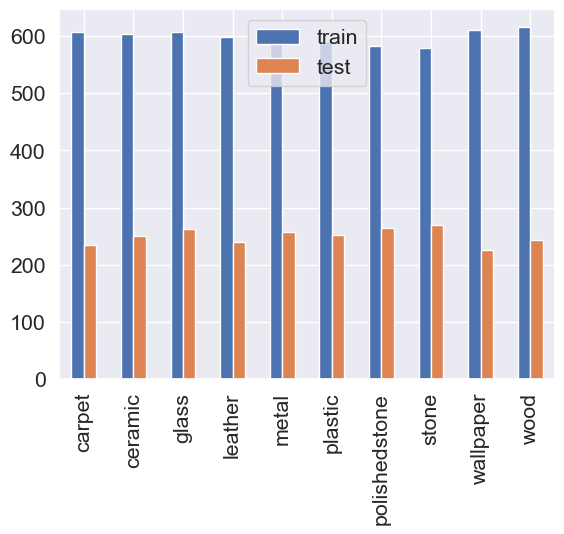

In [69]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

In [34]:
def display_random_image(class_names, train_images, train_labels):

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

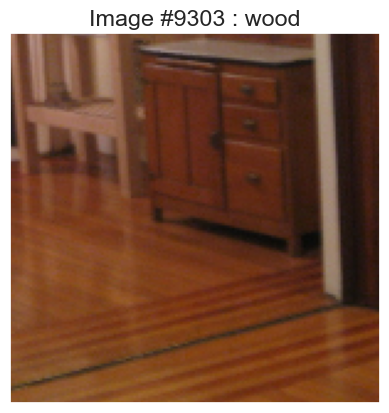

In [98]:
display_random_image(class_names, train_images, train_labels)

In [36]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

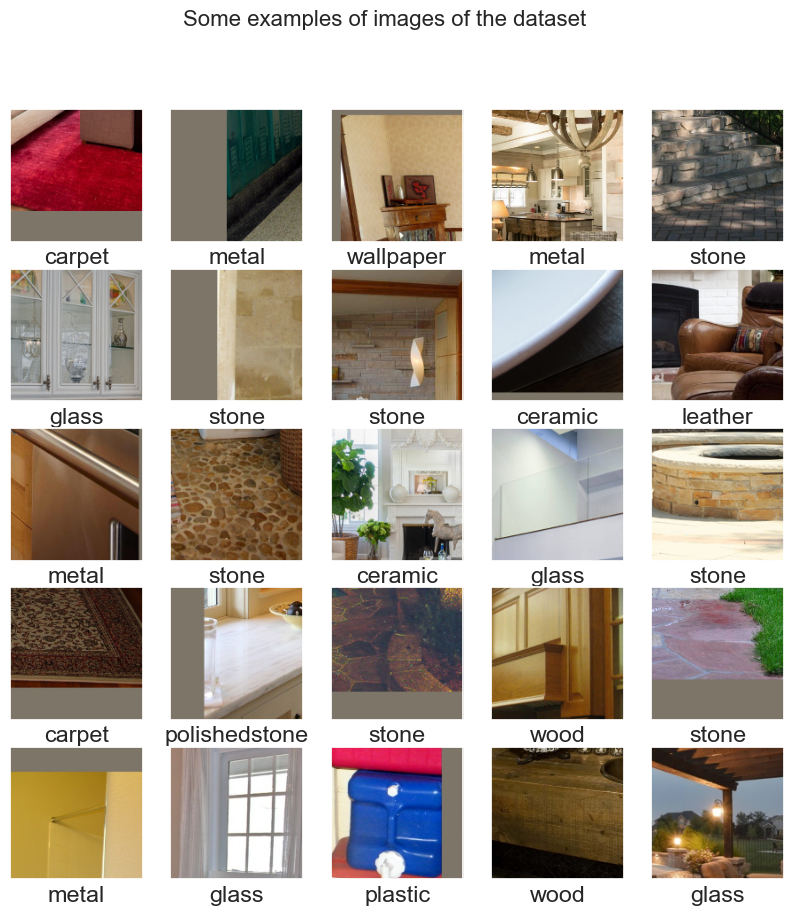

In [79]:

display_examples(class_names, train_images, train_labels)

In [113]:
import tensorflow as tf

# Define the ResNetBlock class
class ResNetBlock(keras.layers.Layer):
    def __init__(self, out_channels, first_stride=1):
        super().__init__()
        
        self.conv_sequence = keras.models.Sequential([
            keras.layers.Conv2D(out_channels, 3, first_stride, padding='same', activation=None),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            keras.layers.Conv2D(out_channels, 3, 1, padding='same', activation=None),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5)
        ])

        self.shortcut = None
        if first_stride > 1 or out_channels != first_stride:
            self.shortcut = keras.layers.Conv2D(out_channels, 1, strides=first_stride, padding='same')

    def call(self, inputs):
        x = self.conv_sequence(inputs)
        shortcut = self.shortcut(inputs) if self.shortcut else inputs
        x += shortcut
        return keras.activations.relu(x)

class ResNet(keras.models.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()

        self.conv_1 = keras.models.Sequential([
            keras.layers.Conv2D(64, 7, 2, padding='same', activation='relu'),
            keras.layers.MaxPooling2D(3, 2, padding='same')
        ])

        self.resnet_chains = keras.models.Sequential([
            ResNetBlock(64), ResNetBlock(64),
            ResNetBlock(128, 2), ResNetBlock(128),
            ResNetBlock(256, 2), ResNetBlock(256),
            ResNetBlock(512, 2), ResNetBlock(512)
        ])

        self.out = keras.models.Sequential([
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, x):
        x = self.conv_1(x)
        x = self.resnet_chains(x)
        x = self.out(x)
        return x

# Number of classes
num_classes = 10

# Instantiate the ResNet model
resnet_model = ResNet(num_classes)


es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (-epoch / 20))
history = resnet_model.fit(
    train_images, train_labels,
    batch_size=128,
    epochs=20,
    validation_split = 0.2,
    callbacks=[es, lr_schedule]
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.1096 - loss: 2.2957 - val_accuracy: 0.1567 - val_loss: 2.2537 - learning_rate: 1.0000e-04
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.1796 - loss: 2.2188 - val_accuracy: 0.1725 - val_loss: 2.2176 - learning_rate: 8.9125e-05
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1862 - loss: 2.1723 - val_accuracy: 0.2250 - val_loss: 2.1538 - learning_rate: 7.9433e-05
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2068 - loss: 2.1509 - val_accuracy: 0.2358 - val_loss: 2.1008 - learning_rate: 7.0795e-05
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2422 - loss: 2.0921 - val_accuracy: 0.2617 - val_loss: 2.0963 - learning_rate: 6.3096e-05
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2637 - loss: 2.0461 - val_accuracy: 0.2475 - val_loss: 2.0733 - learning_rate: 5.6234e-05
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.2741 - loss:

In [114]:
test_loss, test_acc = resnet_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.2f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 215ms/step - accuracy: 0.3757 - loss: 1.7886
Test accuracy: 0.38


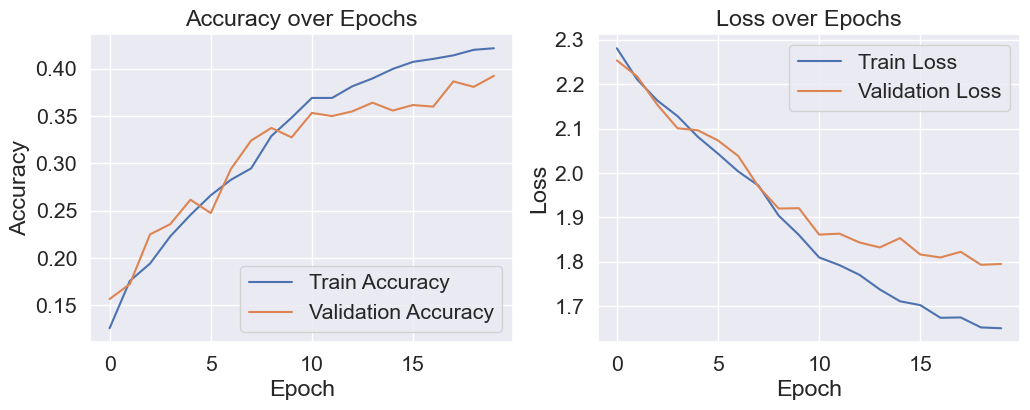

In [115]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 215ms/step


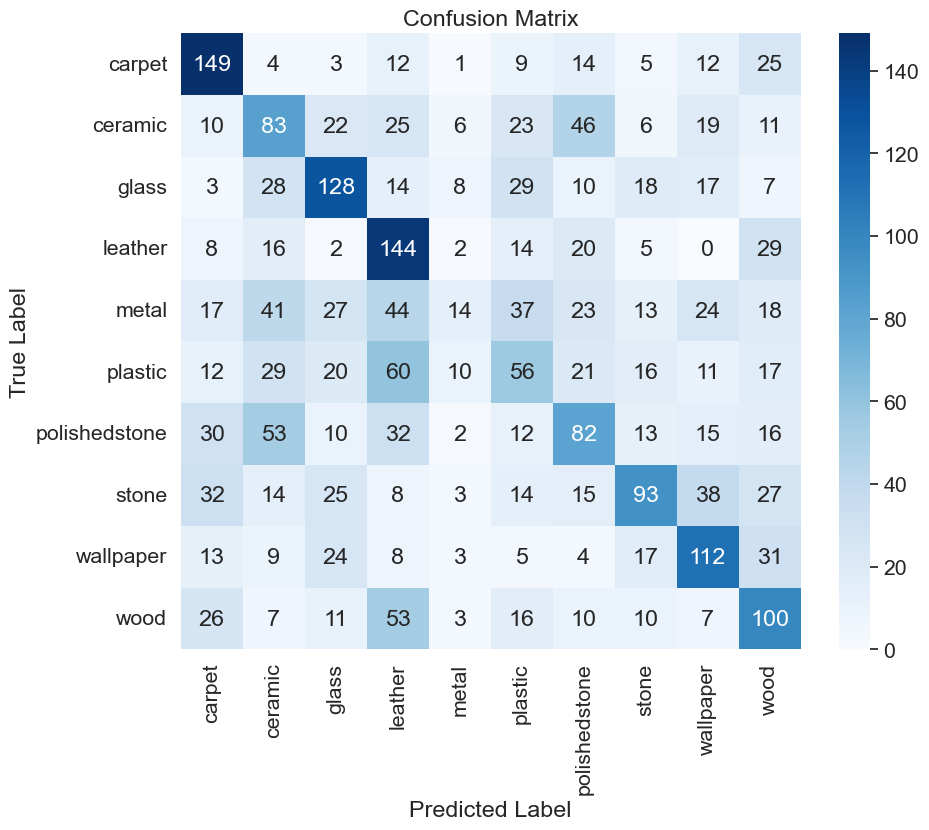

In [116]:
# Confusion matrix
predictions = resnet_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [117]:
print(classification_report(test_labels, predicted_classes, target_names=class_names))
#precision: fe kol el mrat ele twk3t feha kza kant kam mra s7
#recall : mn el actual kza how many did the model find
#f1 : balance between precision and recall
#Support: number of samples

               precision    recall  f1-score   support

       carpet       0.50      0.64      0.56       234
      ceramic       0.29      0.33      0.31       251
        glass       0.47      0.49      0.48       262
      leather       0.36      0.60      0.45       240
        metal       0.27      0.05      0.09       258
      plastic       0.26      0.22      0.24       252
polishedstone       0.33      0.31      0.32       265
        stone       0.47      0.35      0.40       269
    wallpaper       0.44      0.50      0.47       226
         wood       0.36      0.41      0.38       243

     accuracy                           0.38      2500
    macro avg       0.38      0.39      0.37      2500
 weighted avg       0.37      0.38      0.37      2500



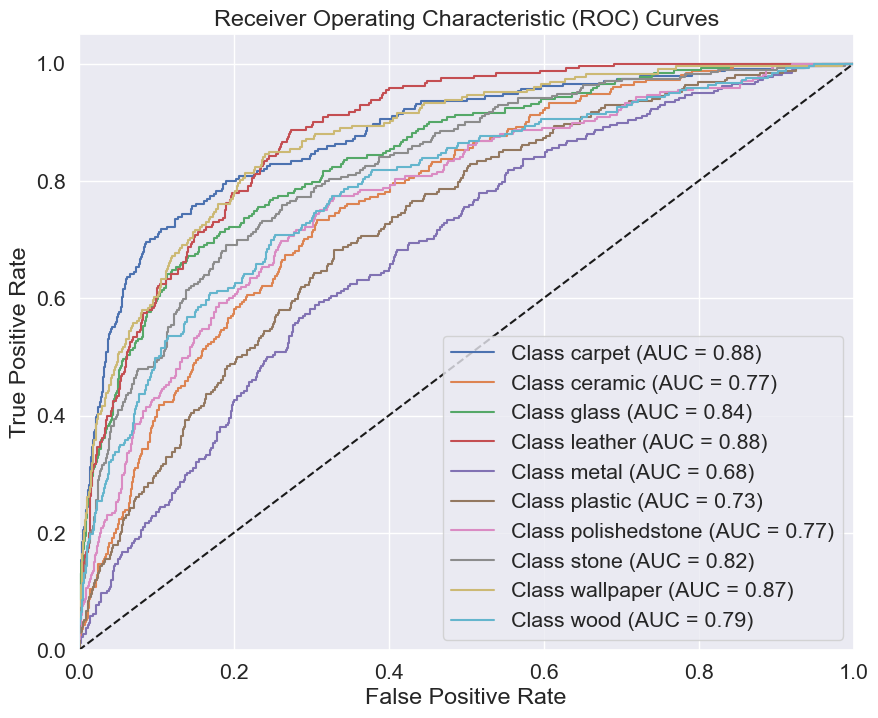

In [118]:
# ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

DENSE

In [22]:
import tensorflow as tf
es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

# Load the DenseNet121 model pre-trained on ImageNet
base_Dense_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model's layers
for layer in base_Dense_model.layers:
    layer.trainable = True

# Set the number of classes
num_classes = 10

# Add a custom classifier on top
Dense_model = tf.keras.models.Sequential([
    base_Dense_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')  
])

# Compile the model
Dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model (assuming train_images, train_labels are your dataset's inputs and labels)
Dense_history = Dense_model.fit(train_images, train_labels, batch_size=128, epochs=3, validation_data=(test_images, test_labels), callbacks=[es])

Epoch 1/3
47/47 ━━━━━━━━━━━━━━━━━━━━ 485s 9s/step - accuracy: 0.1124 - loss: 3.2486 - val_accuracy: 0.1808 - val_loss: 2.4709
Epoch 2/3
47/47 ━━━━━━━━━━━━━━━━━━━━ 407s 9s/step - accuracy: 0.1704 - loss: 2.7205 - val_accuracy: 0.2380 - val_loss: 2.2028
Epoch 3/3
47/47 ━━━━━━━━━━━━━━━━━━━━ 401s 9s/step - accuracy: 0.2259 - loss: 2.4130 - val_accuracy: 0.3184 - val_loss: 2.0140


In [23]:
test_loss, test_acc = Dense_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.2f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 471ms/step - accuracy: 0.3305 - loss: 2.0083
Test accuracy: 0.32


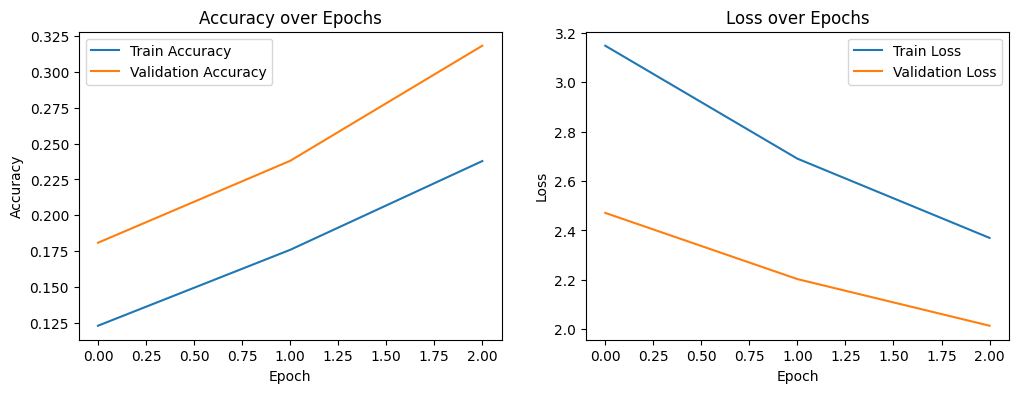

In [24]:
def plot_history(Dense_history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(Dense_history.history['accuracy'], label='Train Accuracy')
    plt.plot(Dense_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Dense_history.history['loss'], label='Train Loss')
    plt.plot(Dense_history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
plot_history(Dense_history)

79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 484ms/step


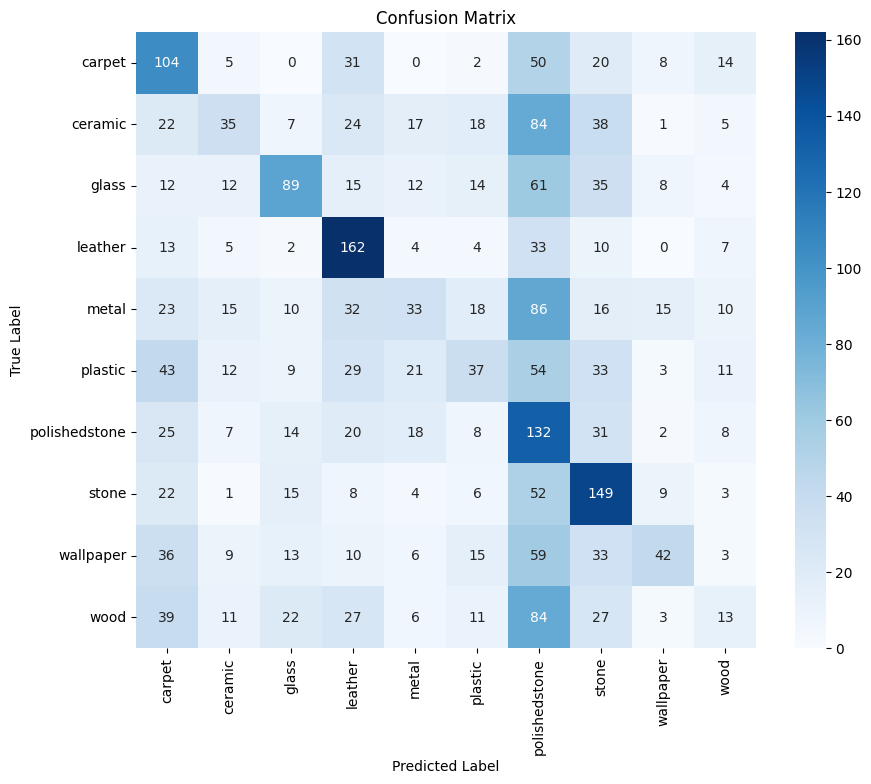

In [25]:
# Confusion matrix
predictions = Dense_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [26]:
print(classification_report(test_labels, predicted_classes, target_names=class_names))

               precision    recall  f1-score   support

       carpet       0.31      0.44      0.36       234
      ceramic       0.31      0.14      0.19       251
        glass       0.49      0.34      0.40       262
      leather       0.45      0.68      0.54       240
        metal       0.27      0.13      0.17       258
      plastic       0.28      0.15      0.19       252
polishedstone       0.19      0.50      0.28       265
        stone       0.38      0.55      0.45       269
    wallpaper       0.46      0.19      0.26       226
         wood       0.17      0.05      0.08       243

     accuracy                           0.32      2500
    macro avg       0.33      0.32      0.29      2500
 weighted avg       0.33      0.32      0.29      2500



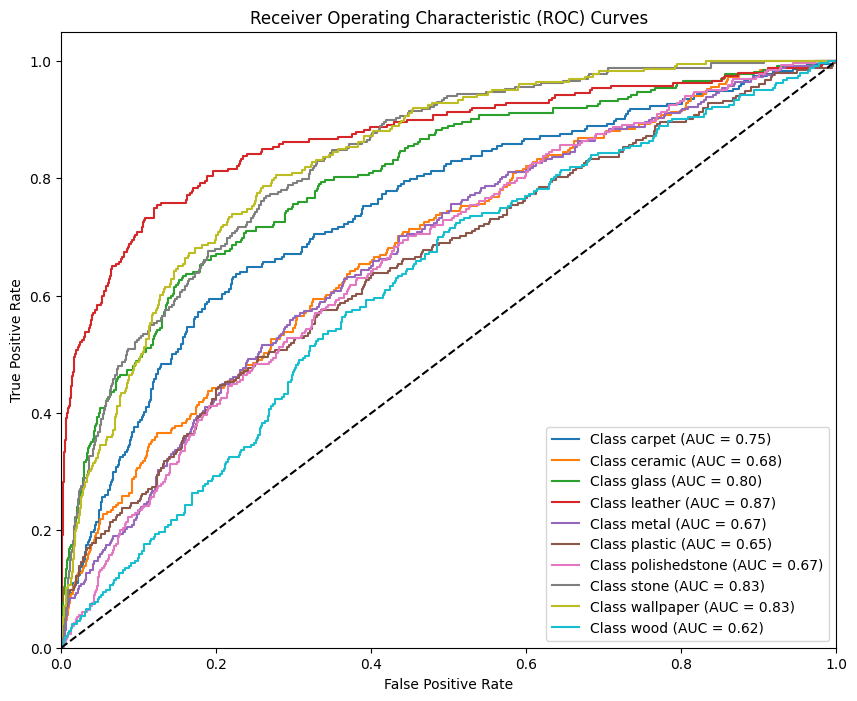

In [27]:
# ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

XCEPTION

In [14]:
import tensorflow as tf
es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

# Load the Xception model pre-trained on ImageNet
base_Xception_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model's layers
for layer in base_Xception_model.layers:
    layer.trainable = True

# Set the number of classes
num_classes = 10

# Add a custom classifier on top
Xception_model = tf.keras.models.Sequential([
    base_Xception_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')  
])

# Compile the model
Xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model (assuming train_images, train_labels are your dataset's inputs and labels)
Xception_history = Xception_model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_data=(test_images, test_labels), callbacks=[es])

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 473s 9s/step - accuracy: 0.1063 - loss: 2.3999 - val_accuracy: 0.1256 - val_loss: 2.2910
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 407s 9s/step - accuracy: 0.1363 - loss: 2.2820 - val_accuracy: 0.1888 - val_loss: 2.2160
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 424s 9s/step - accuracy: 0.2052 - loss: 2.1946 - val_accuracy: 0.2620 - val_loss: 2.1594
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 422s 9s/step - accuracy: 0.2800 - loss: 2.0998 - val_accuracy: 0.3284 - val_loss: 2.0923
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 426s 9s/step - accuracy: 0.3391 - loss: 2.0081 - val_accuracy: 0.3868 - val_loss: 2.0060
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 423s 9s/step - accuracy: 0.3964 - loss: 1.8977 - val_accuracy: 0.4428 - val_loss: 1.9058
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 424s 9s/step - accuracy: 0.4658 - loss: 1.7704 - val_accuracy: 0.4840 - val_loss: 1.7996
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 459s 10s/step - accuracy: 0.5185 - loss: 1.6523 - val_accuracy: 0.5264 - 

In [15]:
test_loss, test_acc = Xception_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.2f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 512ms/step - accuracy: 0.5486 - loss: 1.5139
Test accuracy: 0.56


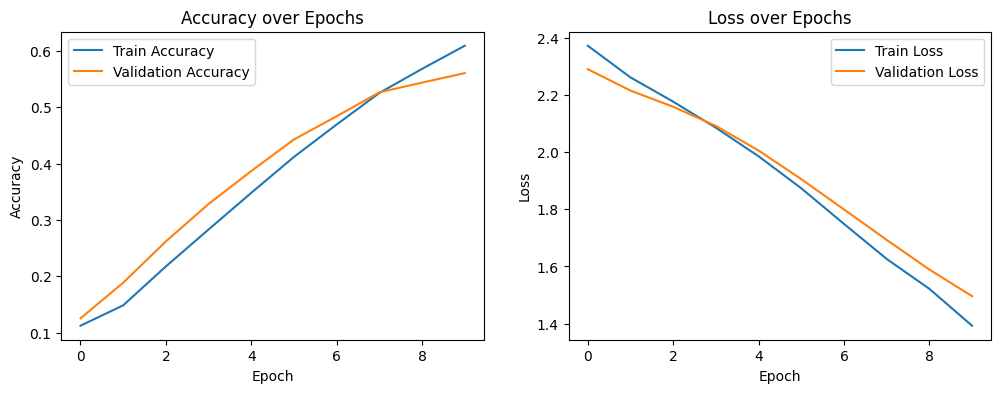

In [21]:
def plot_history(Xception_history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(Xception_history.history['accuracy'], label='Train Accuracy')
    plt.plot(Xception_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Xception_history.history['loss'], label='Train Loss')
    plt.plot(Xception_history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
plot_history(Xception_history)

79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step


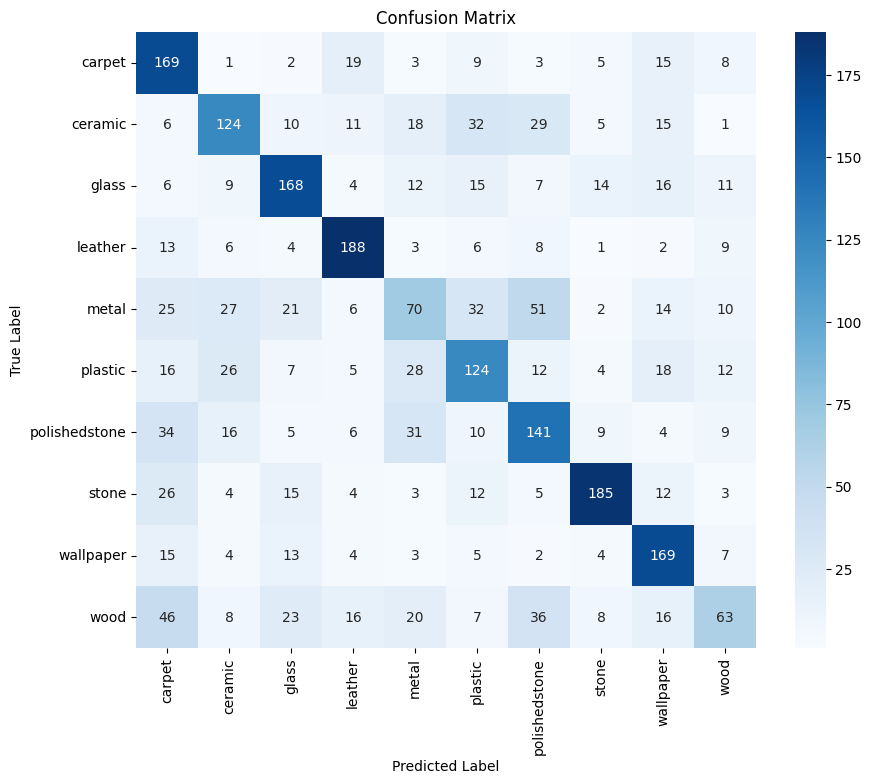

In [17]:
# Confusion matrix
predictions = Xception_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
print(classification_report(test_labels, predicted_classes, target_names=class_names))

               precision    recall  f1-score   support

       carpet       0.47      0.72      0.57       234
      ceramic       0.55      0.49      0.52       251
        glass       0.63      0.64      0.63       262
      leather       0.71      0.78      0.75       240
        metal       0.37      0.27      0.31       258
      plastic       0.49      0.49      0.49       252
polishedstone       0.48      0.53      0.50       265
        stone       0.78      0.69      0.73       269
    wallpaper       0.60      0.75      0.67       226
         wood       0.47      0.26      0.34       243

     accuracy                           0.56      2500
    macro avg       0.56      0.56      0.55      2500
 weighted avg       0.56      0.56      0.55      2500



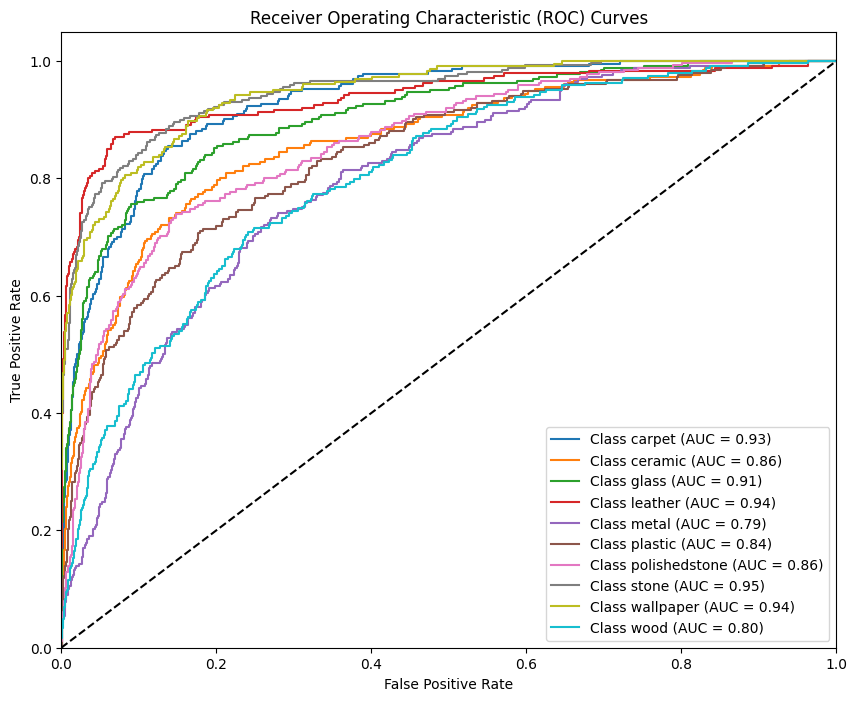

In [19]:
# ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()